In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import sys
import os
# Add this line at the very start of your notebook
sys.path.append(os.path.abspath('..'))  # if notebook is in notebooks/ directory
# or
sys.path.append(os.path.abspath('.'))   # if notebook is in root directory

"""# Then import your modules
from src.Training.trainer import Trainer
from src.Training.solver import Solver"""
from src.Training.NeuralPINN import PINO

c:\Users\mohammed\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)


# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()



In [3]:
from torch.utils.data import Dataset, DataLoader, random_split

def fourier_derivative_2d(u, x, y, order=1):
    """2D spectral derivatives with mirror extension"""
    # Mirror extend in both directions
    u_ext = torch.cat([torch.flip(u, [0]), u, torch.flip(u, [0])], dim=0)
    u_ext = torch.cat([torch.flip(u_ext, [1]), u_ext, torch.flip(u_ext, [1])], dim=1)
    
    nx, ny = u.shape
    dx = 1/32
    dy = 1/32
    
    # 2D FFT on extended domain
    u_hat = torch.fft.fft2(u_ext)
    kx = torch.fft.fftfreq(3*nx, d=dx) * 2 * torch.pi
    ky = torch.fft.fftfreq(3*ny, d=dy) * 2 * torch.pi
    KX, KY = torch.meshgrid(kx, ky, indexing='ij')
    
    # Compute derivatives
    u_x_hat = (1j * KX)**order * u_hat
    u_y_hat = (1j * KY)**order * u_hat
    
    # Transform back and extract original domain
    u_x = torch.fft.ifft2(u_x_hat).real[nx:2*nx, ny:2*ny]
    u_y = torch.fft.ifft2(u_y_hat).real[nx:2*nx, ny:2*ny]
    
    return u_x, u_y
def finite_diff_2d(u, dx=1.0, dy=1.0, order=1):
    """
    2D finite difference derivatives with non-periodic boundaries
    Args:
        u: Input tensor [nx, ny]
        dx, dy: Grid spacing
        order: Derivative order (1 or 2)
    """
    if order == 1:
        # First derivatives
        # Interior points - central differences
        u_x = torch.zeros_like(u)
        u_y = torch.zeros_like(u)
        
        # x-derivative
        u_x[:, 1:-1] = (u[:, 2:] - u[:, :-2]) / (2*dx)
        # Boundaries - one-sided differences
        u_x[:, 0] = (-3*u[:, 0] + 4*u[:, 1] - u[:, 2]) / (2*dx)
        u_x[:, -1] = (3*u[:, -1] - 4*u[:, -2] + u[:, -3]) / (2*dx)
        
        # y-derivative
        u_y[1:-1, :] = (u[2:, :] - u[:-2, :]) / (2*dy)
        # Boundaries
        u_y[0, :] = (-3*u[0, :] + 4*u[1, :] - u[2, :]) / (2*dy)
        u_y[-1, :] = (3*u[-1, :] - 4*u[-2, :] + u[-3, :]) / (2*dy)
        
        return u_x, u_y
        
    elif order == 2:
        dx = 1 /32
        dy = 1/32
        # Second derivatives
        u_xx = torch.zeros_like(u)
        u_yy = torch.zeros_like(u)
        
        # x-direction
        u_xx[:, 1:-1] = (u[:, 2:] - 2*u[:, 1:-1] + u[:, :-2]) / (dx**2)
        # Boundaries using ghost points
        u_xx[:, 0] = (2*u[:, 0] - 5*u[:, 1] + 4*u[:, 2] - u[:, 3]) / (dx**2)
        u_xx[:, -1] = (2*u[:, -1] - 5*u[:, -2] + 4*u[:, -3] - u[:, -4]) / (dx**2)
        
        # y-direction
        u_yy[1:-1, :] = (u[2:, :] - 2*u[1:-1, :] + u[:-2, :]) / (dy**2)
        # Boundaries
        u_yy[0, :] = (2*u[0, :] - 5*u[1, :] + 4*u[2, :] - u[3, :]) / (dy**2)
        u_yy[-1, :] = (2*u[-1, :] - 5*u[-2, :] + 4*u[-3, :] - u[-4, :]) / (dy**2)
        
        return u_xx, u_yy

def derivation(u , x ,  order = 2):

    int_order = int(order)
    alpha = order - int_order
    h = x[1] - x[0]

    for _ in range(int_order):
        u = torch.autograd.grad(u.sum(),x,create_graph=True , retain_graph= True , allow_unused= True)[0]
        #u = finite_diff_2d(u, dx=h, dy=h, order=2)[0]
    return u


class Net(nn.Module):
    def __init__(self,N_input ,N_output , N_Hidden ,N_layers):
        super(Net,self).__init__()
        #activation = SinActivation()
        activation = nn.Tanh()
        self.f1 = nn.Sequential(*[nn.Linear(N_input ,N_Hidden) , activation])
        self.f2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_Hidden , N_Hidden), activation]) for _ in range(N_layers)])
        self.f3 = nn.Sequential(*[nn.Linear(N_Hidden,N_output)])
    def forward(self , x) : 
        x = self.f1(x)
        x = self.f2(x)
        x = self.f3(x)
        return x


# classic Pinns

x = torch.linspace(-1, 1, 32 , requires_grad = True)
y = torch.linspace(-1, 1, 32 , requires_grad= True)
X, Y = torch.meshgrid(x, y)
X = X.unsqueeze(-1)
Y = Y.unsqueeze(-1)
input = torch.cat([X, Y], dim=-1)
print(input.shape)
u_exact = torch.exp(-10*(X**2 + Y**2))
f_exact = torch.exp(-10*(X**2 + Y**2))*(-20)*(1-20*X**2) + torch.exp(-10*(X**2 + Y**2))*(-20)*(1-20*Y**2)


u_left = u_exact[:, 0]
u_right = u_exact[:, -1]
u_bottom = u_exact[0, :]
u_top = u_exact[-1, :]

class PreloadedPINNDataset(Dataset):
    """Preloaded Dataset for Physics-Informed Neural Networks"""
    def __init__(self, x, y, p, u_exact=None, operator=None):
        self.samples = []  # Preload all samples here
        for idx in range(len(p)):
            
            exact = u_exact(x, y, p[idx])

            f = operator(exact, x, y)
            sample = {
            'y': exact,
            'x': f
            }
            self.samples.append(sample)
            


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


# Create dataset
x = torch.linspace(-1, 1, 32, requires_grad=True)
y = torch.linspace(-1, 1, 32, requires_grad=True)
x, y = torch.meshgrid(x, y)
x = x.unsqueeze(-1)
y = y.unsqueeze(-1)

u_exact = lambda x, y, p: torch.exp(p*(-x**2 - y**2))
operator = lambda u, x, y: derivation(u, x, order=2) + derivation(u, y, order=2)
f_exact = lambda x, y, p: (-4*p + 4*p*p*(x*x + y*y)) * torch.exp(p*(-x*x - y*y))

# Preload dataset
p_values = np.linspace(0, 1, 10)
dataset = PreloadedPINNDataset(x, y, p_values, u_exact, operator)

# Split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_loaders = {32: test_loader}
train_loaders = {32: train_loader}



torch.Size([32, 32, 2])


c:\Users\mohammed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
BC = [u_left , u_right , u_bottom , u_top]
p = np.linspace(1, 10, 2)
exact_u = torch.exp(-1*(X**2 + Y**2))
f_train = torch.cat([f_exact(X , Y , p) for p in p] , dim = -1)
u_train = torch.cat([u_exact(X , Y , p) for p in p] , dim = -1)
f_norm = UnitGaussianNormalizer(f_train)
u_norm = UnitGaussianNormalizer(u_train)
f_exact_norm = lambda x , y , p : f_norm.encode(f_exact(x,y,p))[: , :, 0].unsqueeze(-1)
print(f_exact_norm(X,Y,1).shape)
print(f_norm.decode(f_exact(X,Y,1)).shape)
l2_loss = LpLoss(p=2)
model = Net(1,1,100,2)
optimizer = optim.Adam(model.parameters(), lr=0.01)
schedular = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

model = PINO(model , optimizer , schedular)
model.optimizer = optim.Adam(model.model.parameters(), lr=0.01)
model.train(500, X , Y , f_exact , BC  , P=p)


torch.Size([32, 32, 1])
torch.Size([32, 32, 2])
Epoch 0 Loss 2376933.5 , pde loss 2376933.5 , BC loss 0.5955507755279541
Epoch 100 Loss 277.5106201171875 , pde loss 277.5106201171875 , BC loss 2.586652994155884
Epoch 200 Loss 24.852420806884766 , pde loss 24.852420806884766 , BC loss 2.149461030960083
Epoch 300 Loss 71.04095458984375 , pde loss 71.04095458984375 , BC loss 1.8236093521118164
Epoch 400 Loss 16.79336166381836 , pde loss 16.79336166381836 , BC loss 1.5089221000671387


L2 Error: 2.503610
Relative L2 Error: 2.078299
0.045956492


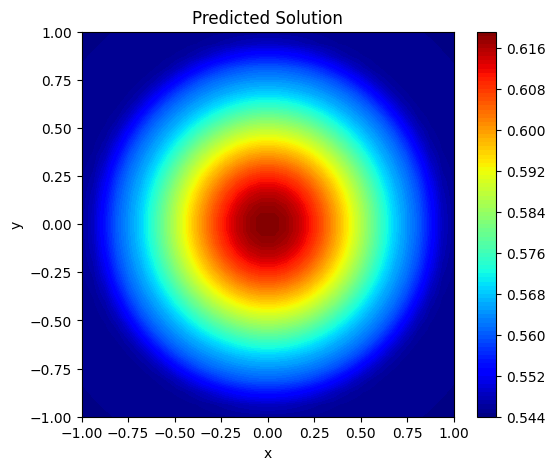

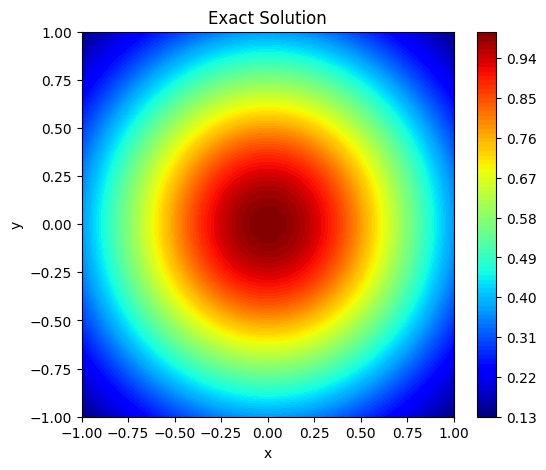

In [9]:
import matplotlib.pyplot as plt
import numpy as np



def calculate_function_space_error(predicted, exact, X, Y):
    """Calculate error in function space norm"""
    
    # Get grid spacing
    dx = X[1,0] - X[0,0]
    dy = Y[0,1] - Y[0,0]
    
    # L2 norm of difference
    diff_squared = (predicted - exact)**2
    L2_error = np.sqrt(np.sum(diff_squared) * dx * dy)
    
    # Relative L2 error
    L2_norm_exact = np.sqrt(np.sum(exact**2) * dx * dy)
    relative_error = L2_error / L2_norm_exact
    
    return L2_error, relative_error



q = 1

# Calculate errors
f_exact = lambda x, y, p: (-4*p + 4*p*p*(x*x + y*y)) * torch.exp(p*(-x*x - y*y))
f = lambda x, y , p : f_exact(x, y, q)
X = torch.linspace(-1, 1, 32, requires_grad=True)
Y = torch.linspace(-1, 1, 32, requires_grad=True)
X, Y = torch.meshgrid(X, Y)
X = X.unsqueeze(-1)
Y = Y.unsqueeze(-1)
u = model.predict(X,Y, f)
#print(u.shape)
#u = u_norm.decode(torch.tensor(u))[: ,: ,0].detach().numpy()
#print(u.shape)
#u = u_pred(f(X,Y , 10)).detach().numpy().squeeze()
a = X.detach().numpy().squeeze()
b = Y.detach().numpy().squeeze()
exact_u = np.exp(-q*(a**2 + b**2))

L2_error, rel_error = calculate_function_space_error(u, exact_u, a, b)
print(f"L2 Error: {L2_error:.6f}")
print(f"Relative L2 Error: {rel_error:.6f}")

print(np.mean((u - exact_u)**2))

plt.figure(figsize=(6,5))
plt.contourf(X.detach().numpy().squeeze(), Y.detach().numpy().squeeze(), u.squeeze(), levels=100, cmap='jet')
plt.colorbar()
plt.title('Predicted Solution')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

plt.figure(figsize=(6,5))
plt.contourf(a , b , exact_u , levels=100 , cmap='jet')
plt.colorbar()

plt.title('Exact Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [10]:
from src.Models.models import PINN_Net


u_pred = PINN_Net(1,1,100,2)
u_pred.load_state_dict(model.model.state_dict())
optimizer = optim.Adam(u_pred.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=50,
    min_lr=1e-6
)

f_model = Net(1,1,100,2)
f_optimizer = optim.Adam(f_model.parameters(), lr=0.01)
f_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    f_optimizer, 
    mode='min',
    factor=0.5,
    patience=50,
    min_lr=1e-6
)
f_target = f_exact(X,Y,10)
u_target = torch.exp(-10*(X**2 + Y**2))
def Standardize(x):
    return (x - x.mean()) / x.std() , x.mean() , x.std()

def DeStandardize(x, mean, std):
    return x * std + mean

#f_target , mean , std = Standardize(f_target)

for ep in range(1000):
    
    optimizer.zero_grad()
    #f_optimizer.zero_grad()
    
    u_pred.train()
    #u = model.model(f_target)
    u = u_pred(f_target)
    f_pred = derivation(u.squeeze(),X,order = 2) + derivation(u.squeeze(),Y,order = 2)
    #f_pred = f_model(u)
    BC_loss = F.mse_loss(u[:, 0],BC[0]) + F.mse_loss(u[:, -1],BC[1]) + F.mse_loss(u[0,:],BC[2]) + F.mse_loss(u[-1,:],BC[3])

    loss = F.mse_loss(f_pred.squeeze(),f_target.squeeze()) + BC_loss + 0.1*F.mse_loss(u.squeeze(),u_target.squeeze())
    loss.backward(retain_graph=True)
    optimizer.step()
    scheduler.step(metrics=loss)
    """if ep % 10 == 0:
        f_loss = F.mse_loss(f_pred.squeeze(),f_target.squeeze())
        f_optimizer.step()
        f_scheduler.step(metrics=f_loss)"""
    
    if ep % 100 == 0:
        print(loss.item())  






13.947317123413086
2.294156312942505
1.8956815004348755
1.792575716972351
1.7562724351882935
1.7380956411361694
1.7299681901931763
1.7261110544204712
1.7235406637191772
1.721543550491333


In [10]:
import torch
import torch.nn as nn
import numpy as np
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import sympy as sp

class IntegrationGNN(MessagePassing):
    def __init__(self, in_channels=1, hidden_channels=64):
        super().__init__(aggr='add')
        
        self.node_mlp = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU()
        )
        
        self.weight_mlp = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Softplus()
        )
    
    def forward(self, x, edge_index):
        # Transform node features
        node_features = self.node_mlp(x)
        
        # Message passing
        hidden = self.propagate(edge_index, x=node_features)
        
        # Compute weights
        weights = self.weight_mlp(hidden)
        return weights
    
    def integrate(self, x, edge_index, f_values):
        weights = self.forward(x, edge_index)
        return torch.sum(weights * f_values)

def create_training_data(n_points=50):
    """Create training data with known integrals"""
    x = torch.linspace(0, 1, n_points).view(-1, 1)
    
    # Create edges between nearby points
    edge_list = []
    eps = 0.2
    for i in range(n_points):
        for j in range(n_points):
            if i != j and abs(x[i] - x[j]) < eps:
                edge_list.append([i, j])
    
    edge_index = torch.tensor(edge_list, dtype=torch.long).t()
    
    return Data(x=x, edge_index=edge_index)

# Test functions for comparison
def test_functions():
    return [
        (lambda x: torch.sin(2 * np.pi * x), "sin(2*pi*x)"),
        (lambda x: x**2, "x**2"),
        (lambda x: torch.exp(-x), "exp(-x)"),
    ]

# Calculate symbolic integrals using SymPy
def get_sympy_integral(expr_str, a=0, b=1):
    x = sp.Symbol('x')
    expr = sp.sympify(expr_str)
    return float(sp.integrate(expr, (x, a, b)))

# Train the model
model = IntegrationGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
graph = create_training_data()

# Training loop
print("Training GNN integrator...")
for epoch in range(500):
    model.train()
    total_loss = 0
    
    for func, expr in test_functions():
        # Get true integral from SymPy
        true_integral = get_sympy_integral(expr)
        
        # Compute GNN integral
        f_values = func(graph.x)
        pred_integral = model.integrate(graph.x, graph.edge_index, f_values)
        
        loss = (pred_integral - true_integral)**2
        total_loss += loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss.item():.6f}")

# Compare results
print("\nComparison of Integration Methods:")
print("-" * 50)
print(f"{'Function':<15} {'SymPy':<15} {'GNN':<15} {'Error':<15}")
print("-" * 50)

model.eval()
with torch.no_grad():
    for func, expr in test_functions():
        # SymPy integral
        true_integral = get_sympy_integral(expr)
        
        # GNN integral
        f_values = func(graph.x)
        gnn_integral = model.integrate(graph.x, graph.edge_index, f_values)
        
        error = abs(true_integral - gnn_integral.item())
        
        print(f"{expr:<15} {true_integral:<15.6f} {gnn_integral.item():<15.6f} {error:<15.6f}")

c:\Users\mohammed\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training GNN integrator...
Epoch 0, Loss: 22.113745
Epoch 100, Loss: 0.059726
Epoch 200, Loss: 0.001184
Epoch 300, Loss: 0.001083
Epoch 400, Loss: 0.001028

Comparison of Integration Methods:
--------------------------------------------------
Function        SymPy           GNN             Error          
--------------------------------------------------
sin(2*pi*x)     0.000000        0.022810        0.022810       
x**2            0.333333        0.351893        0.018559       
exp(-x)         0.632121        0.620974        0.011147       


In [14]:
import torch
import torch.nn as nn
import numpy as np
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import sympy as sp

class Integration2DGNN(MessagePassing):
    def __init__(self, in_channels=2, hidden_channels=64):
        super().__init__(aggr='add')
        
        self.node_mlp = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU()
        )
        
        self.weight_mlp = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Softplus()
        )
    
    def forward(self, x, edge_index):
        node_features = self.node_mlp(x)
        hidden = self.propagate(edge_index, x=node_features)
        weights = self.weight_mlp(hidden)
        return weights
    
    def integrate(self, x, edge_index, f_values):
        weights = self.forward(x, edge_index)
        return torch.sum(weights * f_values)

def create_2d_grid(n_points=20):
    """Create 2D grid for integration"""
    x = torch.linspace(0, 1, n_points)
    y = torch.linspace(0, 1, n_points)
    X, Y = torch.meshgrid(x, y)
    points = torch.stack([X.flatten(), Y.flatten()], dim=1)
    
    # Create edges between nearby points
    edge_list = []
    eps = 0.2
    for i in range(len(points)):
        for j in range(len(points)):
            if i != j and torch.norm(points[i] - points[j]) < eps:
                edge_list.append([i, j])
    
    edge_index = torch.tensor(edge_list, dtype=torch.long).t()
    return Data(x=points, edge_index=edge_index)

def test_functions_2d():
    return [
        (lambda x, y: torch.sin(2*np.pi*x)*torch.sin(2*np.pi*y), "sin(2*pi*x)*sin(2*pi*y)"),
        (lambda x, y: torch.exp(-(x**2 + y**2)), "exp(-(x**2 + y**2))"),
        (lambda x, y: x**2 + y**2, "x**2 + y**2")
    ]

def get_sympy_integral_2d(expr_str, ax=0, bx=1, ay=0, by=1):
    x, y = sp.symbols('x y')
    expr = sp.sympify(expr_str)
    return float(sp.integrate(sp.integrate(expr, (x, ax, bx)), (y, ay, by)))

# Initialize model and data
model = Integration2DGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
graph = create_2d_grid()

# Training loop
print("Training 2D GNN integrator...")
for epoch in range(500):
    model.train()
    total_loss = 0
    
    for func, expr in test_functions_2d():
        true_integral = get_sympy_integral_2d(expr)
        f_values = func(graph.x[:, 0], graph.x[:, 1])
        pred_integral = model.integrate(graph.x, graph.edge_index, f_values)
        
        loss = (pred_integral - true_integral)**2
        total_loss += loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss.item():.6f}")

# Compare results
print("\nComparison of 2D Integration Methods:")
print("-" * 60)
print(f"{'Function':<20} {'SymPy':<15} {'GNN':<15} {'Error':<15}")
print("-" * 60)

model.eval()
with torch.no_grad():
    for func, expr in test_functions_2d():
        true_integral = get_sympy_integral_2d(expr)
        f_values = func(graph.x[:, 0], graph.x[:, 1])
        gnn_integral = model.integrate(graph.x, graph.edge_index, f_values)
        error = abs(true_integral - gnn_integral.item())
        
        print(f"{expr:<20} {true_integral:<15.6f} {gnn_integral.item():<15.6f} {error:<15.6f}")

Training 2D GNN integrator...
Epoch 0, Loss: 7791984128.000000
Epoch 100, Loss: 25621.871094
Epoch 200, Loss: 5941.367676
Epoch 300, Loss: 2720.715820
Epoch 400, Loss: 1579.069824

Comparison of 2D Integration Methods:
------------------------------------------------------------
Function             SymPy           GNN             Error          
------------------------------------------------------------
sin(2*pi*x)*sin(2*pi*y) 0.000000        -0.000000       0.000000       
exp(-(x**2 + y**2))  0.557746        20.785032       20.227286      
x**2 + y**2          0.666667        25.725086       25.058420      


In [22]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import numpy as np

class Integration2DGNN(MessagePassing):
    def __init__(self, in_channels=2, hidden_channels=64):
        super().__init__(aggr='add')
        self.node_mlp = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU()
        )
        self.weight_mlp = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1),
            nn.Softplus()
        )
    
    def forward(self, x, edge_index):
        node_features = self.node_mlp(x)
        hidden = self.propagate(edge_index, x=node_features)
        weights = self.weight_mlp(hidden)
        return weights
    
    def integrate(self, x, edge_index, f_values):
        weights = self.forward(x, edge_index)
        return torch.sum(weights * f_values)
    
class NormalizationUtil:
    def __init__(self, exact_values):
        self.min_val = min(exact_values)
        self.max_val = max(exact_values)
    
    def normalize(self, value):
        return (value - self.min_val) / (self.max_val - self.min_val)
    
    def denormalize(self, value):
        return value * (self.max_val - self.min_val) + self.min_val

def create_2d_grid(n_points=20):
    x = torch.linspace(-1, 1, n_points)
    y = torch.linspace(-1, 1, n_points)
    X, Y = torch.meshgrid(x, y, indexing='ij')
    points = torch.stack([X.flatten(), Y.flatten()], dim=1)
    print(points.shape)
    edge_list = []
    eps = 0.2
    for i in range(len(points)):
        for j in range(i+1, len(points)):
            if torch.norm(points[i] - points[j]) < eps:
                edge_list.append([i, j])
                edge_list.append([j, i])
    
    edge_index = torch.tensor(edge_list, dtype=torch.long).t()
    return Data(x=points, edge_index=edge_index)

def test_functions():
    return [
        (lambda x, y: torch.sin(np.pi*x)*torch.sin(np.pi*y), 4/(np.pi**2)),
        (lambda x, y: torch.exp(-x**2 - y**2), np.pi*(1-np.exp(-1))),
        (lambda x, y: x**2 + y**2, 8/3)
    ]

# Initialize normalization
exact_values = [val for _, val in test_functions()]
norm_util = NormalizationUtil(exact_values)
normalized_funcs = [(f, norm_util.normalize(val)) for f, val in test_functions()]


# Modified training loop
model = Integration2DGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
graph = create_2d_grid()

for epoch in range(4000):
    model.train()
    total_loss = 0
    
    for func, norm_exact in normalized_funcs:
        f_values = func(graph.x[:, 0], graph.x[:, 1])
        pred_integral = model.integrate(graph.x, graph.edge_index, f_values)
        loss = (pred_integral - norm_exact)**2
        total_loss += loss
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss.item():.6f}")
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

# Results comparison with denormalization
print("\nResults:")
print("-" * 50)
print(f"{'Function':<20} {'Exact':<15} {'GNN':<15} {'Error':<15}")
print("-" * 50)

model.eval()
with torch.no_grad():
    for (func, _), (_, norm_exact) in zip(test_functions(), normalized_funcs):
        f_values = func(graph.x[:, 0], graph.x[:, 1])
        gnn_integral = model.integrate(graph.x, graph.edge_index, f_values)
        denorm_pred = norm_util.denormalize(gnn_integral.item())
        exact_val = norm_util.denormalize(norm_exact)
        error = abs(exact_val - denorm_pred)
        print(f"{func.__name__:<20} {exact_val:<15.6f} {denorm_pred:<15.6f} {error:<15.6f}")

Epoch 0, Loss: 7564354560.000000
Epoch 100, Loss: 79234.921875
Epoch 200, Loss: 44280.777344
Epoch 300, Loss: 26404.828125
Epoch 400, Loss: 17031.113281
Epoch 500, Loss: 11696.037109
Epoch 600, Loss: 8436.745117
Epoch 700, Loss: 6323.469727
Epoch 800, Loss: 34.265244
Epoch 900, Loss: 13.173603
Epoch 1000, Loss: 7.236487
Epoch 1100, Loss: 4.550520
Epoch 1200, Loss: 3.081061
Epoch 1300, Loss: 2.185075
Epoch 1400, Loss: 1.599096
Epoch 1500, Loss: 1.196658
Epoch 1600, Loss: 0.910218
Epoch 1700, Loss: 0.700767
Epoch 1800, Loss: 0.544397
Epoch 1900, Loss: 0.425715
Epoch 2000, Loss: 0.334483
Epoch 2100, Loss: 0.263633
Epoch 2200, Loss: 0.208174
Epoch 2300, Loss: 0.164501
Epoch 2400, Loss: 0.129954
Epoch 2500, Loss: 0.102540
Epoch 2600, Loss: 0.080748
Epoch 2700, Loss: 0.063410
Epoch 2800, Loss: 0.049621
Epoch 2900, Loss: 0.038668
Epoch 3000, Loss: 0.029988
Epoch 3100, Loss: 0.023131
Epoch 3200, Loss: 0.017734
Epoch 3300, Loss: 0.013508
Epoch 3400, Loss: 0.010219
Epoch 3500, Loss: 0.007675
Epo

In [3]:
import torch.nn as nn

class PoissonNeuralOperator(nn.Module):
    def __init__(self, hidden_dim):
        super(PoissonNeuralOperator, self).__init__()
        self.encoder = nn.Sequential(
            # Maps input function to latent space
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        self.kernel_net = nn.Sequential(
            # Learns the kernel k(x,y)
            nn.Linear(2, hidden_dim),  # Takes (x,y) pairs
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)   # Outputs kernel value
        )
        
        self.decoder = nn.Sequential(
            # Maps from latent space to solution
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, f):
        # x: grid points
        # f: source function values at grid points
        
        # Encode input function
        f_encoded = self.encoder(f)
        
        # Compute kernel values for all pairs of points
        kernel_values = torch.zeros((len(x), len(x)))
        for i in range(len(x)):
            for j in range(len(x)):
                xy_pair = torch.tensor([x[i], x[j]])
                kernel_values[i,j] = self.kernel_net(xy_pair)
        
        # Perform numerical integration
        u_latent = torch.matmul(kernel_values, f_encoded)
        
        # Decode to get solution
        u = self.decoder(u_latent)
        return u, kernel_values
    
def train_step(model, optimizer, x_grid, f_train, u_true):
    optimizer.zero_grad()
    
    # Forward pass
    u_pred, k_pred = model(x_grid, f_train)
    
    # Loss computation
    mse_loss = torch.mean((u_pred - u_true)**2)
    
    # Add physics-informed loss
    #laplacian_u = compute_laplacian(u_pred, x_grid)
    #physics_loss = torch.mean((laplacian_u + f_train)**2)
    
    total_loss = mse_loss #+ physics_loss
    
    # Backward pass
    total_loss.backward()
    optimizer.step()
    
    return total_loss



model = PoissonNeuralOperator(hidden_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
x_grid = torch.linspace(0, 1, 50).view(-1, 1)
f_train = torch.sin(2*np.pi*x_grid)
u_true = -1/(2*np.pi)**2 * torch.sin(2*np.pi*x_grid)

for epoch in range(1000):
    loss = train_step(model, optimizer, x_grid, f_train, u_true)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.2271026074886322
Epoch 100, Loss: 1.3106423466524575e-05
Epoch 200, Loss: 6.2834856180415954e-06
Epoch 300, Loss: 3.3533804071339546e-06
Epoch 400, Loss: 2.0616573692677775e-06
Epoch 500, Loss: 1.2199225238873623e-06
Epoch 600, Loss: 7.926473131192324e-07
Epoch 700, Loss: 5.697285700989596e-07
Epoch 800, Loss: 4.1455521682109975e-07
Epoch 900, Loss: 3.3549221711837163e-07


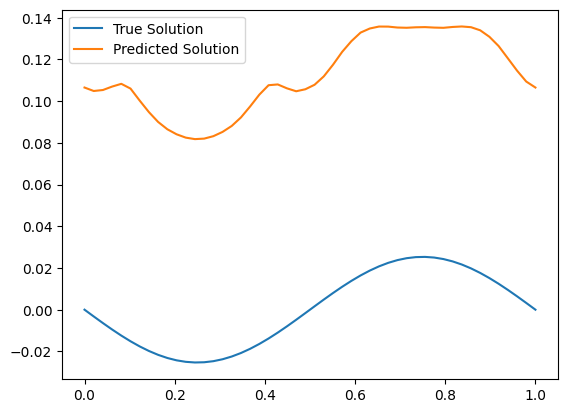

In [5]:
import matplotlib.pyplot as plt

u_pred = model(f_train, x_grid)[0]

plt.plot(x_grid, u_true, label='True Solution')
plt.plot(x_grid, u_pred.detach(), label='Predicted Solution')
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        # Number of Fourier modes to multiply
        self.modes1 = modes1
        self.modes2 = modes2

        # Complex weights for Fourier layer
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes1, modes2, 2))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, modes1, modes2, 2))

    def compl_mul2d(self, input, weights):
        # Complex multiplication in the Fourier space
        print(input.shape , weights.shape)
        return torch.stack([
            input[..., 0] * weights[..., 0] - input[..., 1] * weights[..., 1],
            input[..., 0] * weights[..., 1] + input[..., 1] * weights[..., 0]
        ], dim=-1)

    def forward(self, x):
        batchsize = x.shape[0]
        size1, size2 = x.shape[1], x.shape[2]

        # Compute Fourier coefficients
        x_ft = torch.fft.rfft2(x, norm='ortho')
        x_ft = torch.stack([x_ft.real, x_ft.imag], dim=-1)
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, size1, size2//2 + 1, 2, device=x.device)
        out_ft[:, :self.modes1, :self.modes2] = self.compl_mul2d(
            x_ft[:, :self.modes1, :self.modes2], 
            self.weights1
        )
        out_ft[:, -self.modes1:, :self.modes2] = self.compl_mul2d(
            x_ft[:, -self.modes1:, :self.modes2], 
            self.weights2
        )

        # Return to physical space
        x = torch.complex(out_ft[..., 0], out_ft[..., 1])
        x = torch.fft.irfft2(x, s=(size1, size2), norm='ortho')
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()
        self.modes1 = modes1  # Number of Fourier modes
        self.modes2 = modes2
        self.width = width    # Number of channels

        # Input layer
        self.fc0 = nn.Linear(3, self.width)  # 3 = (x,y,f(x,y))
        
        # Fourier layers
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        
        # Linear layers
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        
        # Output layer
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # x shape: (batch_size, size_x, size_y, 3)
        batch_size = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2]

        # Lift to higher dimensional space
        x = self.fc0(x.float())
        x = x.permute(0, 3, 1, 2)
        
        # Apply Fourier layers with residual connections
        print(x.shape)
        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        
        # Project back to output space
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

def train_fno_poisson(model, train_loader, optimizer, epochs):
    """Training loop for FNO Poisson solver"""
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x)
            
            # MSE loss
            mse_loss = F.mse_loss(out.view(-1), y.view(-1))
            
            # Add physics-informed loss (Laplacian)
            f = x[..., 2:3]  # Source term
            u_xx = torch.gradient(torch.gradient(out, dim=1)[0], dim=1)[0]
            u_yy = torch.gradient(torch.gradient(out, dim=2)[0], dim=2)[0]
            physics_loss = F.mse_loss(u_xx + u_yy + f.squeeze(-1), torch.zeros_like(f.squeeze(-1)))
            
            loss = mse_loss + physics_loss
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader):.6f}')

# Example usage
def create_poisson_dataset(n_samples, grid_size):
    """Creates synthetic dataset for Poisson equation"""
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    xx, yy = np.meshgrid(x, y)
    
    data = []
    for _ in range(n_samples):
        # Random frequency components for source term
        k1, k2 = np.random.randint(1, 5, size=2)
        f = np.sin(k1 * np.pi * xx) * np.sin(k2 * np.pi * yy)
        
        # Analytical solution
        u = -f / ((k1**2 + k2**2) * np.pi**2)
        
        # Stack grid coordinates and source term
        grid_data = np.stack([xx, yy, f], axis=-1)
        data.append((grid_data, u))
    
    return data


data = create_poisson_dataset(1000, 16)
train_loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)

model = FNO2d(modes1=16, modes2=16, width=24)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_fno_poisson(model, train_loader, optimizer, epochs=100)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (800x32 and 1x32)